# Mini Project 2: Rabbits and Foxes in Daisyworld

The first vairiable that I will add to daisy world is the addition of rabbits. Rabbits will significantly effect the existing factors of the daisyworld model. The rabbit population will be measured in terms of fractional coverage, say rabbits per square kilometer. As the rabbit population increases, the population of the daisies will decrease. I chose the amount of daisies to have a logarithmic relationship to the rabbit population. For instance, as the daisy population gets closer to zero, it will have a higher effect on the rabbit population.

## Example 1: Add rabbits to daisy world

#### Summary of updated equations for the addition of rabbits:

Fraction of white daisies

\begin{equation}
\frac{dA_w}{dt} = A_w(\beta_w x - \chi - A_r*\gamma)
\end{equation}

Fraction of black daisies
\begin{equation}
\frac{dA_b}{dt} = A_b(\beta_b x - \chi - A_r*\gamma)
\end{equation}

Fraction of rabbits
\begin{equation}
\frac{dA_r}{dt} = A_r(\beta_r \gamma- \chi_r)
\end{equation}

Function of how daisy population effects rabbit birth rate
\begin{equation}
\gamma = \frac{\ln(A_w + A_b +1)}{\ln(2)}
\end{equation}
$\gamma$ represents how the population of daisies has an increasing effect on the rabbit population as the population of daisies becomes lower and lower. For example the difference of having 10000 arcres of daisies available, and 5000 acres of daisies available should not effect the rabbit population as much as the difference of having 5000 acres and 10 acres of available daisies.


In [75]:
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np


class IntegTim(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rabbitconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [3] with the white [0] and black [1]
                    daisy fractiion.
                    Also the rabbit fraction is included, which is [2]
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L* user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        #print('debug ',yvals, albedo_p)
        #print('debug ',eta)
        #debug
        return (temp_w, temp_b, temp_e)


    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=fraction of rabbits
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
            
        temp_r = temp_e    
        if(temp_r >= 280 and temp_r <= 308 ):
            beta_r = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_r = 0.0
            
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        gamma = np.log(y[0]+y[1] +1)/np.log(2)
       
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi - y[2]*gamma)
        f[1] = y[1] * (beta_b * bare - user.chi - y[2]*gamma)
        f[2] = y[2] * (beta_r * gamma - user.rchi)
        
        return f


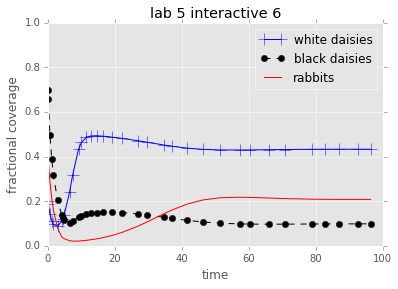

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("ggplot")

theSolver=IntegTim('r_adapt.yaml')
timeVals,yVals,errorList=theSolver.timeloop5Err()

yvals=pd.DataFrame.from_records(yVals,columns=['white','black','rabbit'])
thefig,theAx=plt.subplots(1,1)

points,=theAx.plot(timeVals,yvals['white'],'-b+',label='white daisies')
points.set_markersize(12)
theLine1,=theAx.plot(timeVals,yvals['black'],'--ko',label='black daisies')
theLine2,=theAx.plot(timeVals,yvals['rabbit'],'-r',label='rabbits')
theAx.set_title('lab 5 interactive 6')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
theAx.set_ylim(0,1)
out=theAx.legend(loc='best')



## Add Arctic Foxes to daisy world

Fraction of rabbits
\begin{equation}
\frac{dA_r}{dt} = A_r(\beta_r \gamma- \chi_r - K_f A_f)
\end{equation}

Fraction of foxes
\begin{equation}
\frac{dA_f}{dt} = A_f(\beta_f \varphi- \chi_f)
\end{equation}

Function of how daisy population effects rabbit birth rate
\begin{equation}
\gamma = \frac{\ln(A_w + A_b +1)}{\ln(2)}
\end{equation}

Function of how rabbit population effects fox birth rate
\begin{equation}
\varphi = \frac{\ln(A_r +1)}{\ln(2)}
\end{equation}

Log functions are used because I wanted population of prey (daisies or rabbits) to have a non linear relationship to the preditor birth rates. For isntance, if daisy populaions reduced from 1000 to 500, it would have a lower impact than if the population reduced from 600 to 100.

All other formulas will remain the same as example 1

### Assumptions
1. Rabbits eat both black and white daisies equally
2. Death rate for plants and animals is constant
3. Species do not go extinct at fractions between 0 and 1
4. daisy, rabbit, and fox fractions are per square kilometer
5. each time step represents a daisyworld year
6. Foxes need cooler temperatures to thrive on daisy world


In [78]:
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np


class IntegTim(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rabbitconc,\
            self.initvars.foxconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [3] with the white [0] and black [1]
                    daisy fractiion.
                    Also the rabbit fraction is included, which is [2]
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L* user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        #print('debug ',yvals, albedo_p)
        #print('debug ',eta)
        #debug
        return (temp_w, temp_b, temp_e)
    
    def find_temp1(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [3] with the white [0] and black [1]
                    daisy fractiion.
                    Also the rabbit fraction is included, which is [2]
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L* user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        #print('debug ',yvals, albedo_p)
        #print('debug ',eta)
        #debug
        return (temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=fraction of rabbits on planet
           y[3]=fraction of foxes on planet
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
            
        temp_r = temp_e    
        if(temp_r >= 280 and temp_r <= 328 ):
            beta_r = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_r = 0.0
        
        # artcic foxes
        temp_f = temp_e    
        if(temp_f >= 260 and temp_r <= 295 ):
            beta_f = 1.0 - 0.003265 * (280.0 - temp_w)**2.0
        else:
            beta_f = 0.0
            
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        gamma = np.log(y[0]+y[1] +1)/np.log(2)
        phi   = np.log(y[2]+1)/np.log(2)
       
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi - y[2]*user.rabbit_eat)
        f[1] = y[1] * (beta_b * bare - user.chi - y[2]*user.rabbit_eat)
        f[2] = y[2] * (beta_r * gamma - user.rchi - user.foxkillrate*y[3])
        f[3] = y[3] * (beta_f * phi - user.fchi)

        return (f)
    

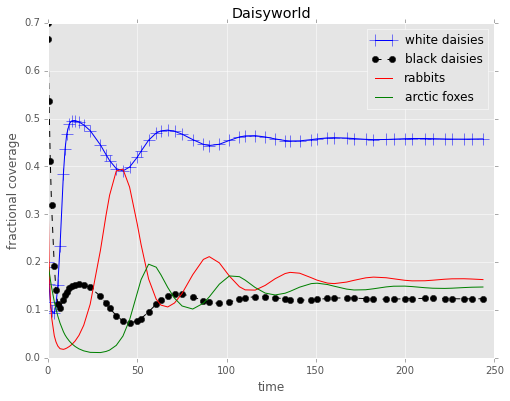

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("ggplot")

theSolver=IntegTim('rf_adapt.yaml')
timeVals,yVals,errorList=theSolver.timeloop5Err()

yvals=pd.DataFrame.from_records(yVals,columns=['white','black','rabbit','fox'])
thefig,theAx=plt.subplots(1,1,figsize=(8,6))

points,=theAx.plot(timeVals,yvals['white'],'-b+',label='white daisies')
points.set_markersize(12)
theLine1,=theAx.plot(timeVals,yvals['black'],'--ko',label='black daisies')
theLine2,=theAx.plot(timeVals,yvals['rabbit'],'-r',label='rabbits')
theLine3,=theAx.plot(timeVals,yvals['fox'],'-g',label='arctic foxes')

theAx.set_title('Daisyworld')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
#theAx.set_ylim(0,1)
out=theAx.legend(loc='best')


## Discussion

1. In the first graph when only rabbits and daisies were present in daisyworld, the white and black daisies both decreased in total population. Here is is a assumed that rabbit birthrate is dependent on temperature similar to the the daisy requirements. So as daisies find an equalibruim temerature, so do the rabbits. 

2. When foxes are added to daisyworld there is instability for each population for over 150 time steps. Before I elaborate more on this I will state all the initial values.
   - daisy death rate: 0.3
   - rabbit death rate: 0.5
   - fox death rate: 0.15
   - rate at which foxes kill rabbits: 0.7
   - rate at which rabbits eat daisies: 0.5
   - initial white daisies: 0.2
   - initial black daisies: 0.7
   - initial rabbits: 0.4
   - initial foxes: 0.2

3. The life span for foxes and rabbits can be estimated by the death rate for each. the rabbit death rate is 0.5, which would mean after every year on daisy world, 50% of the rabbit population would die off. This would give an average lifespan of 1 year for rabbits. The average life span of the artic foxes would be 3.3 years. 

4. Since the foxes are arctic foxes, their birth rate will be effected by the warmer temperatures of daisy world, which counter acts their relativly longer life span.

5. The initial oscilation is due to the rabbits having a very small amount of preditors. Once the population of foxes is high enough to effect the rabbits, the rabbits population falls and the fox population rises. Eventually the all species tend to a non zero steady state.
